In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
module = fc.eightb.preselection.t8btag_minmass
dout = "ranked_quadh"

In [4]:
signal = ObjIter([ Tree(f) for f in module.signal_list ])
bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List), Tree(module.Run2_UL18.TTJets)])
data = ObjIter([ Tree(module.JetHT_Data_UL_List) ])

100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


In [5]:
bkg.reweight(2.3)
bkg.set_systematics(0.2)

[None, None]

In [6]:
# (signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ordered='pt'), report=True)

t8btag = CollectionFilter('jet', filter=lambda t: ak_rank(-t.jet_btag, axis=-1) < 8)
signal = signal.apply(t8btag)
bkg = bkg.apply(t8btag)
data = data.apply(t8btag)

In [7]:
path = f"/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker/20221115_ranger_lr0.0047_batch512_m7m10m12/"


In [8]:
(signal+bkg+data).apply(lambda t : eightb.load_quadh(t, path), report=True)
# (signal).apply(lambda t : eightb.load_quadh(t, path), report=True)


100%|██████████| 6/6 [00:28<00:00,  4.76s/it]


[None, None, None, None, None, None]

In [9]:
(signal+bkg+data).apply(lambda t : eightb.pair_y_from_higgs(t, operator=eightb.y_min_mass_asym), report=True)

100%|██████████| 6/6 [00:22<00:00,  3.77s/it]


[None, None, None, None, None, None]

In [10]:
select_jetpt = eightb.selected_jet_ptregressed()

signal = signal.apply(select_jetpt)
bkg = bkg.apply(select_jetpt)
data = data.apply(select_jetpt)

In [11]:
select_jetbtagwp = eightb.selected_jet_btagwp()

signal = signal.apply(select_jetbtagwp)
bkg = bkg.apply(select_jetbtagwp)
data = data.apply(select_jetbtagwp)

In [12]:
def build_bdt_features(t):
    jet_ht = ak.sum(t.jet_ptRegressed,axis=-1)

    j1_phi, j2_phi = ak.unzip(ak.combinations(t.jet_phi, n=2, axis=-1))
    jet_dphi = calc_dphi(j1_phi, j2_phi)

    j1_eta, j2_eta = ak.unzip(ak.combinations(t.jet_eta, n=2, axis=-1))
    jet_deta = calc_deta(j1_eta, j2_eta)

    min_jet_deta = ak.min( np.abs(jet_deta), axis=-1)
    max_jet_deta = ak.max( np.abs(jet_deta), axis=-1)

    jet_dr = np.sqrt( jet_deta**2 + jet_dphi**2 )

    min_jet_dr = ak.min(jet_dr, axis=-1)
    max_jet_dr = ak.max(jet_dr, axis=-1)

    h1_phi, h2_phi = ak.unzip(ak.combinations(t.higgs_phi, n=2, axis=-1))
    higgs_dphi = calc_dphi(h1_phi, h2_phi)

    h1_eta, h2_eta = ak.unzip(ak.combinations(t.higgs_eta, n=2, axis=-1))
    higgs_deta = calc_deta(h1_eta, h2_eta)

    comb_id = ak.combinations(np.arange(4), n=2, axis=0)
    t.extend(
        jet_ht=jet_ht,
        min_jet_deta=min_jet_deta,
        max_jet_deta=max_jet_deta,
        min_jet_dr=min_jet_dr,
        max_jet_dr=max_jet_dr,
        h_h_dphi=np.abs(higgs_dphi),
        h_h_deta=np.abs(higgs_deta)
    )
(signal+bkg+data).apply(build_bdt_features, report=True)

100%|██████████| 6/6 [00:03<00:00,  1.56it/s]


[None, None, None, None, None, None]

100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


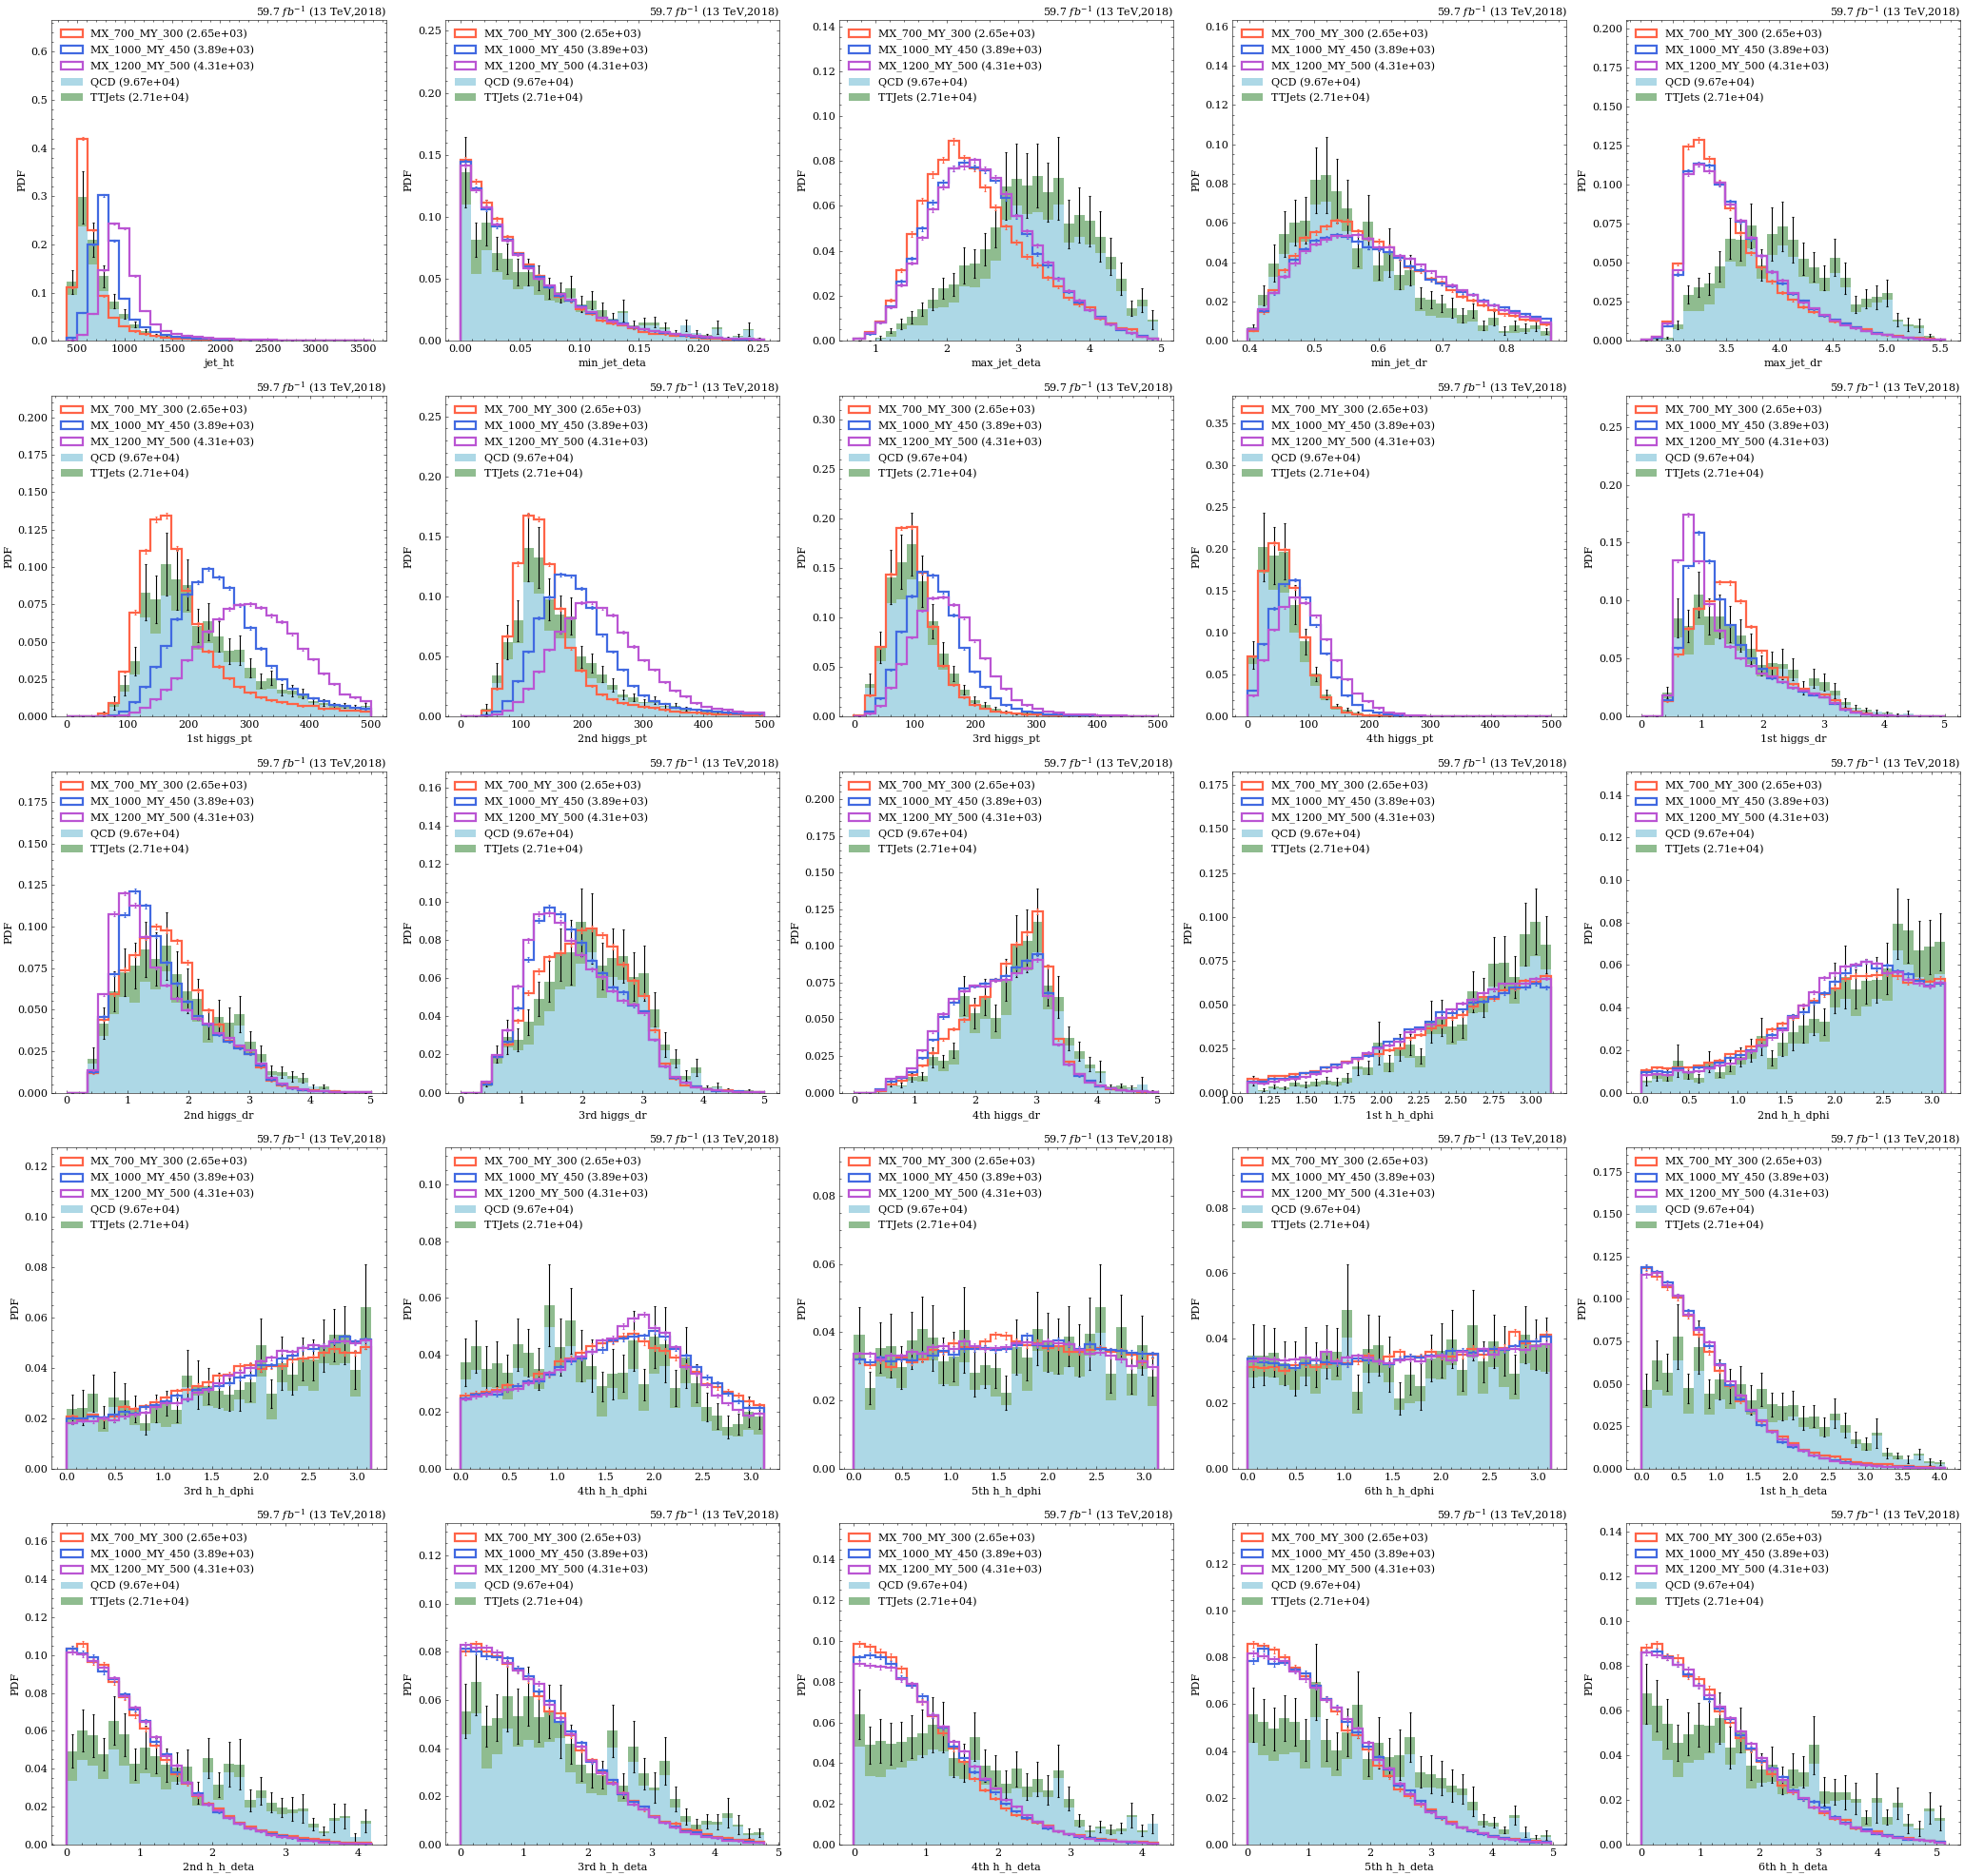

In [74]:
study.quick( 
    signal+bkg,
    legend=True,
    varlist=[
        'jet_ht','min_jet_deta','max_jet_deta','min_jet_dr','max_jet_dr'
    ] + [
        f'higgs_{var}[:,{i}]'
        for var in ('pt','dr')
        for i in range(4)
    ] + [
        f'h_h_{var}[:,{i}]'
        for var in ('dphi','deta')
        for i in range(6)
    ],
    efficiency=True

)

100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


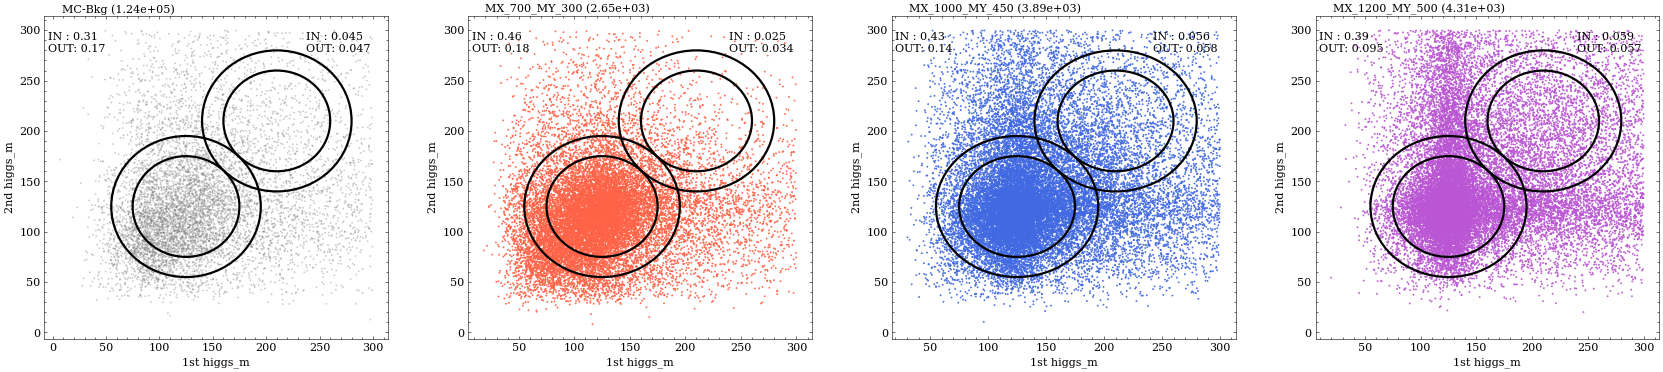

In [56]:
# ar_center = (125,125,30, 45)
# vr_center = (180,180,30, 45)

ar_center = [125,125]
vr_center = [210,210]
sr_r, cr_r =  50, 70

study.quick2d(
    signal+bkg,
    varlist=['higgs_m[:,0]','higgs_m[:,1]'],
    exe=[
        draw_concentric(*ar_center, sr_r, cr_r, linewidth=2),
        draw_concentric(*vr_center, sr_r, cr_r, text=(0.75,0.95), linewidth=2),
    ],
    scatter=True,
)

In [67]:
def higgs_dm(t, r = ar_center):
    dm = ak.zeros_like(t.Run)
    for i, m in enumerate(r):
        dm = dm + ( t.higgs_m[:,i] - m )**2
    dm = np.sqrt(dm)
    t.extend(higgs_dm = dm)
(signal+bkg+data).apply(higgs_dm)

[None, None, None, None, None, None]

In [58]:
def val_higgs_dm(t, r =  vr_center):
    dm = ak.zeros_like(t.Run)
    for i, m in enumerate(r):
        dm = dm + ( t.higgs_m[:,i] - m )**2
    dm = np.sqrt(dm)
    t.extend(val_higgs_dm = dm)
(signal+bkg+data).apply(val_higgs_dm)

[None, None, None, None, None, None]

In [75]:
features = [
        'jet_ht','min_jet_deta','max_jet_deta','min_jet_dr','max_jet_dr'
    ] + [
        f'higgs_{var}[:,{i}]'
        for var in ('pt','dr')
        for i in range(4)
    ] + [
        f'h_h_{var}[:,{i}]'
        for var in ('dphi','deta')
        for i in range(6)
    ]

In [76]:
ar_bdt = ABCD(
    features=features,
    a = lambda t : (t.n_medium_btag >  4) & (t.higgs_dm < sr_r),
    b = lambda t : (t.n_medium_btag <= 4) & (t.higgs_dm < sr_r),
    c = lambda t : (t.n_medium_btag >  4) & (t.higgs_dm > sr_r) & (t.higgs_dm < cr_r),
    d = lambda t : (t.n_medium_btag <= 4) & (t.higgs_dm > sr_r) & (t.higgs_dm < cr_r),
)

In [77]:
vr_bdt = ABCD(
    features=features,
    a = lambda t : (t.n_medium_btag >  4) & (t.val_higgs_dm < sr_r),
    b = lambda t : (t.n_medium_btag <= 4) & (t.val_higgs_dm < sr_r),
    c = lambda t : (t.n_medium_btag >  4) & (t.val_higgs_dm > sr_r) & (t.val_higgs_dm < cr_r),
    d = lambda t : (t.n_medium_btag <= 4) & (t.val_higgs_dm > sr_r) & (t.val_higgs_dm < cr_r),
)

In [49]:
blind_filter = EventFilter('blinded', filter=lambda t : ~( ar_bdt.a(t) ))
blinded_data  = data.apply(blind_filter)

In [50]:
bkg_model = blinded_data .asmodel('bkg model')

In [51]:
ar_yields = [ ak.sum(bkg_model.apply(getattr(ar_bdt, region)).awk,axis=1) for region in ('a','b','c','d') ]
ar_yields

[<Array [0] type='1 * int64'>,
 <Array [25715] type='1 * int64'>,
 <Array [4378] type='1 * int64'>,
 <Array [14149] type='1 * int64'>]

In [52]:
vr_yields = [ ak.sum(bkg_model.apply(getattr(vr_bdt, region)).awk,axis=1) for region in ('a','b','c','d') ]
vr_yields

[<Array [1362] type='1 * int64'>,
 <Array [4541] type='1 * int64'>,
 <Array [1516] type='1 * int64'>,
 <Array [4980] type='1 * int64'>]

In [53]:
ar_yields[2]/ar_yields[3],vr_yields[2]/vr_yields[3]

(<Array [0.309] type='1 * float64'>, <Array [0.304] type='1 * float64'>)

In [78]:
vr_bdt.train(bkg_model)
vr_bdt.print_results(bkg_model)

--- ABCD Results ---
k = 3.044e-01
k*(b/a)-1  = 1.49%
BDT(b)/a-1 = 1.49%



100%|██████████| 25/25 [01:17<00:00,  3.10s/it]


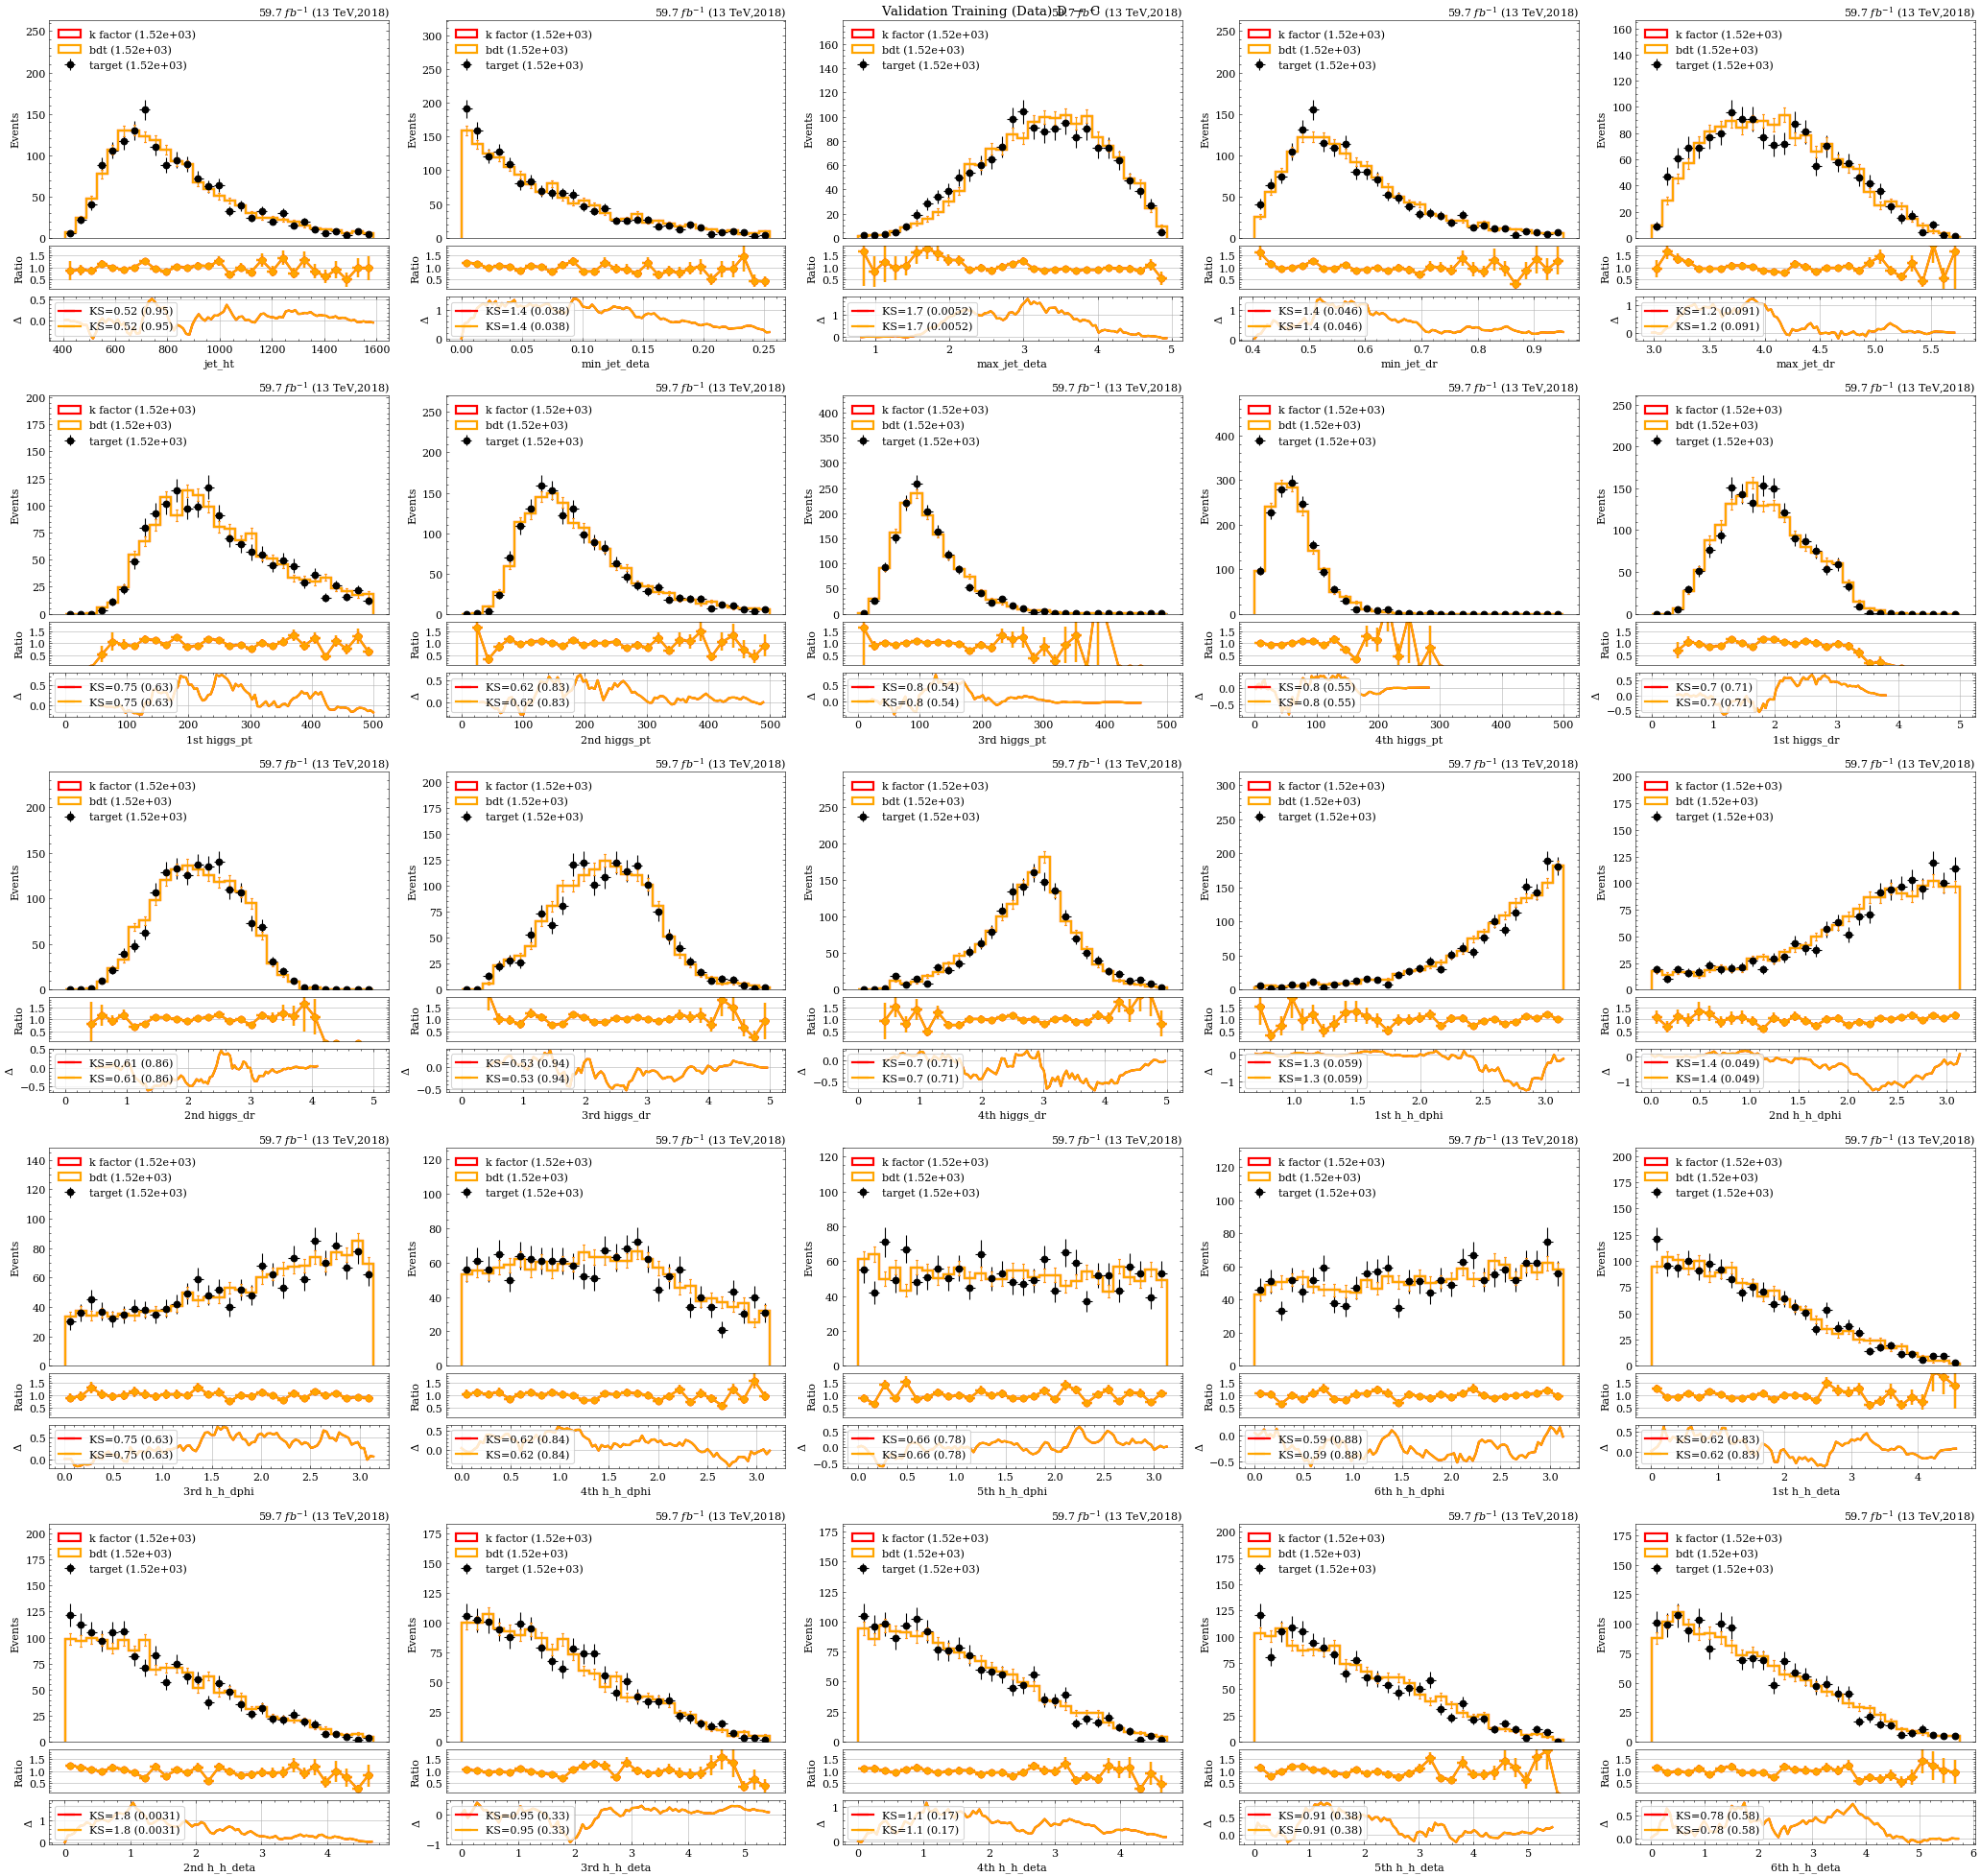

In [80]:
study.quick_region(
    blinded_data , bkg_model, bkg_model, label=['target','k factor','bdt'],
    h_color=['black','red','orange'], legend=True,
    masks=[vr_bdt.c]*len(data)+[vr_bdt.d]*(len(bkg_model)*2),
    scale=[1]*len(data)+[vr_bdt.scale_tree]*len(bkg_model)+[vr_bdt.reweight_tree]*len(bkg_model),
    varlist=vr_bdt.feature_names,
    suptitle='Validation Training (Data) D $\\rightarrow$ C',
    ratio=True,
    **study.kstest,
    saveas=f'{dout}/vr_bdt/training'
)

100%|██████████| 25/25 [01:13<00:00,  2.95s/it]


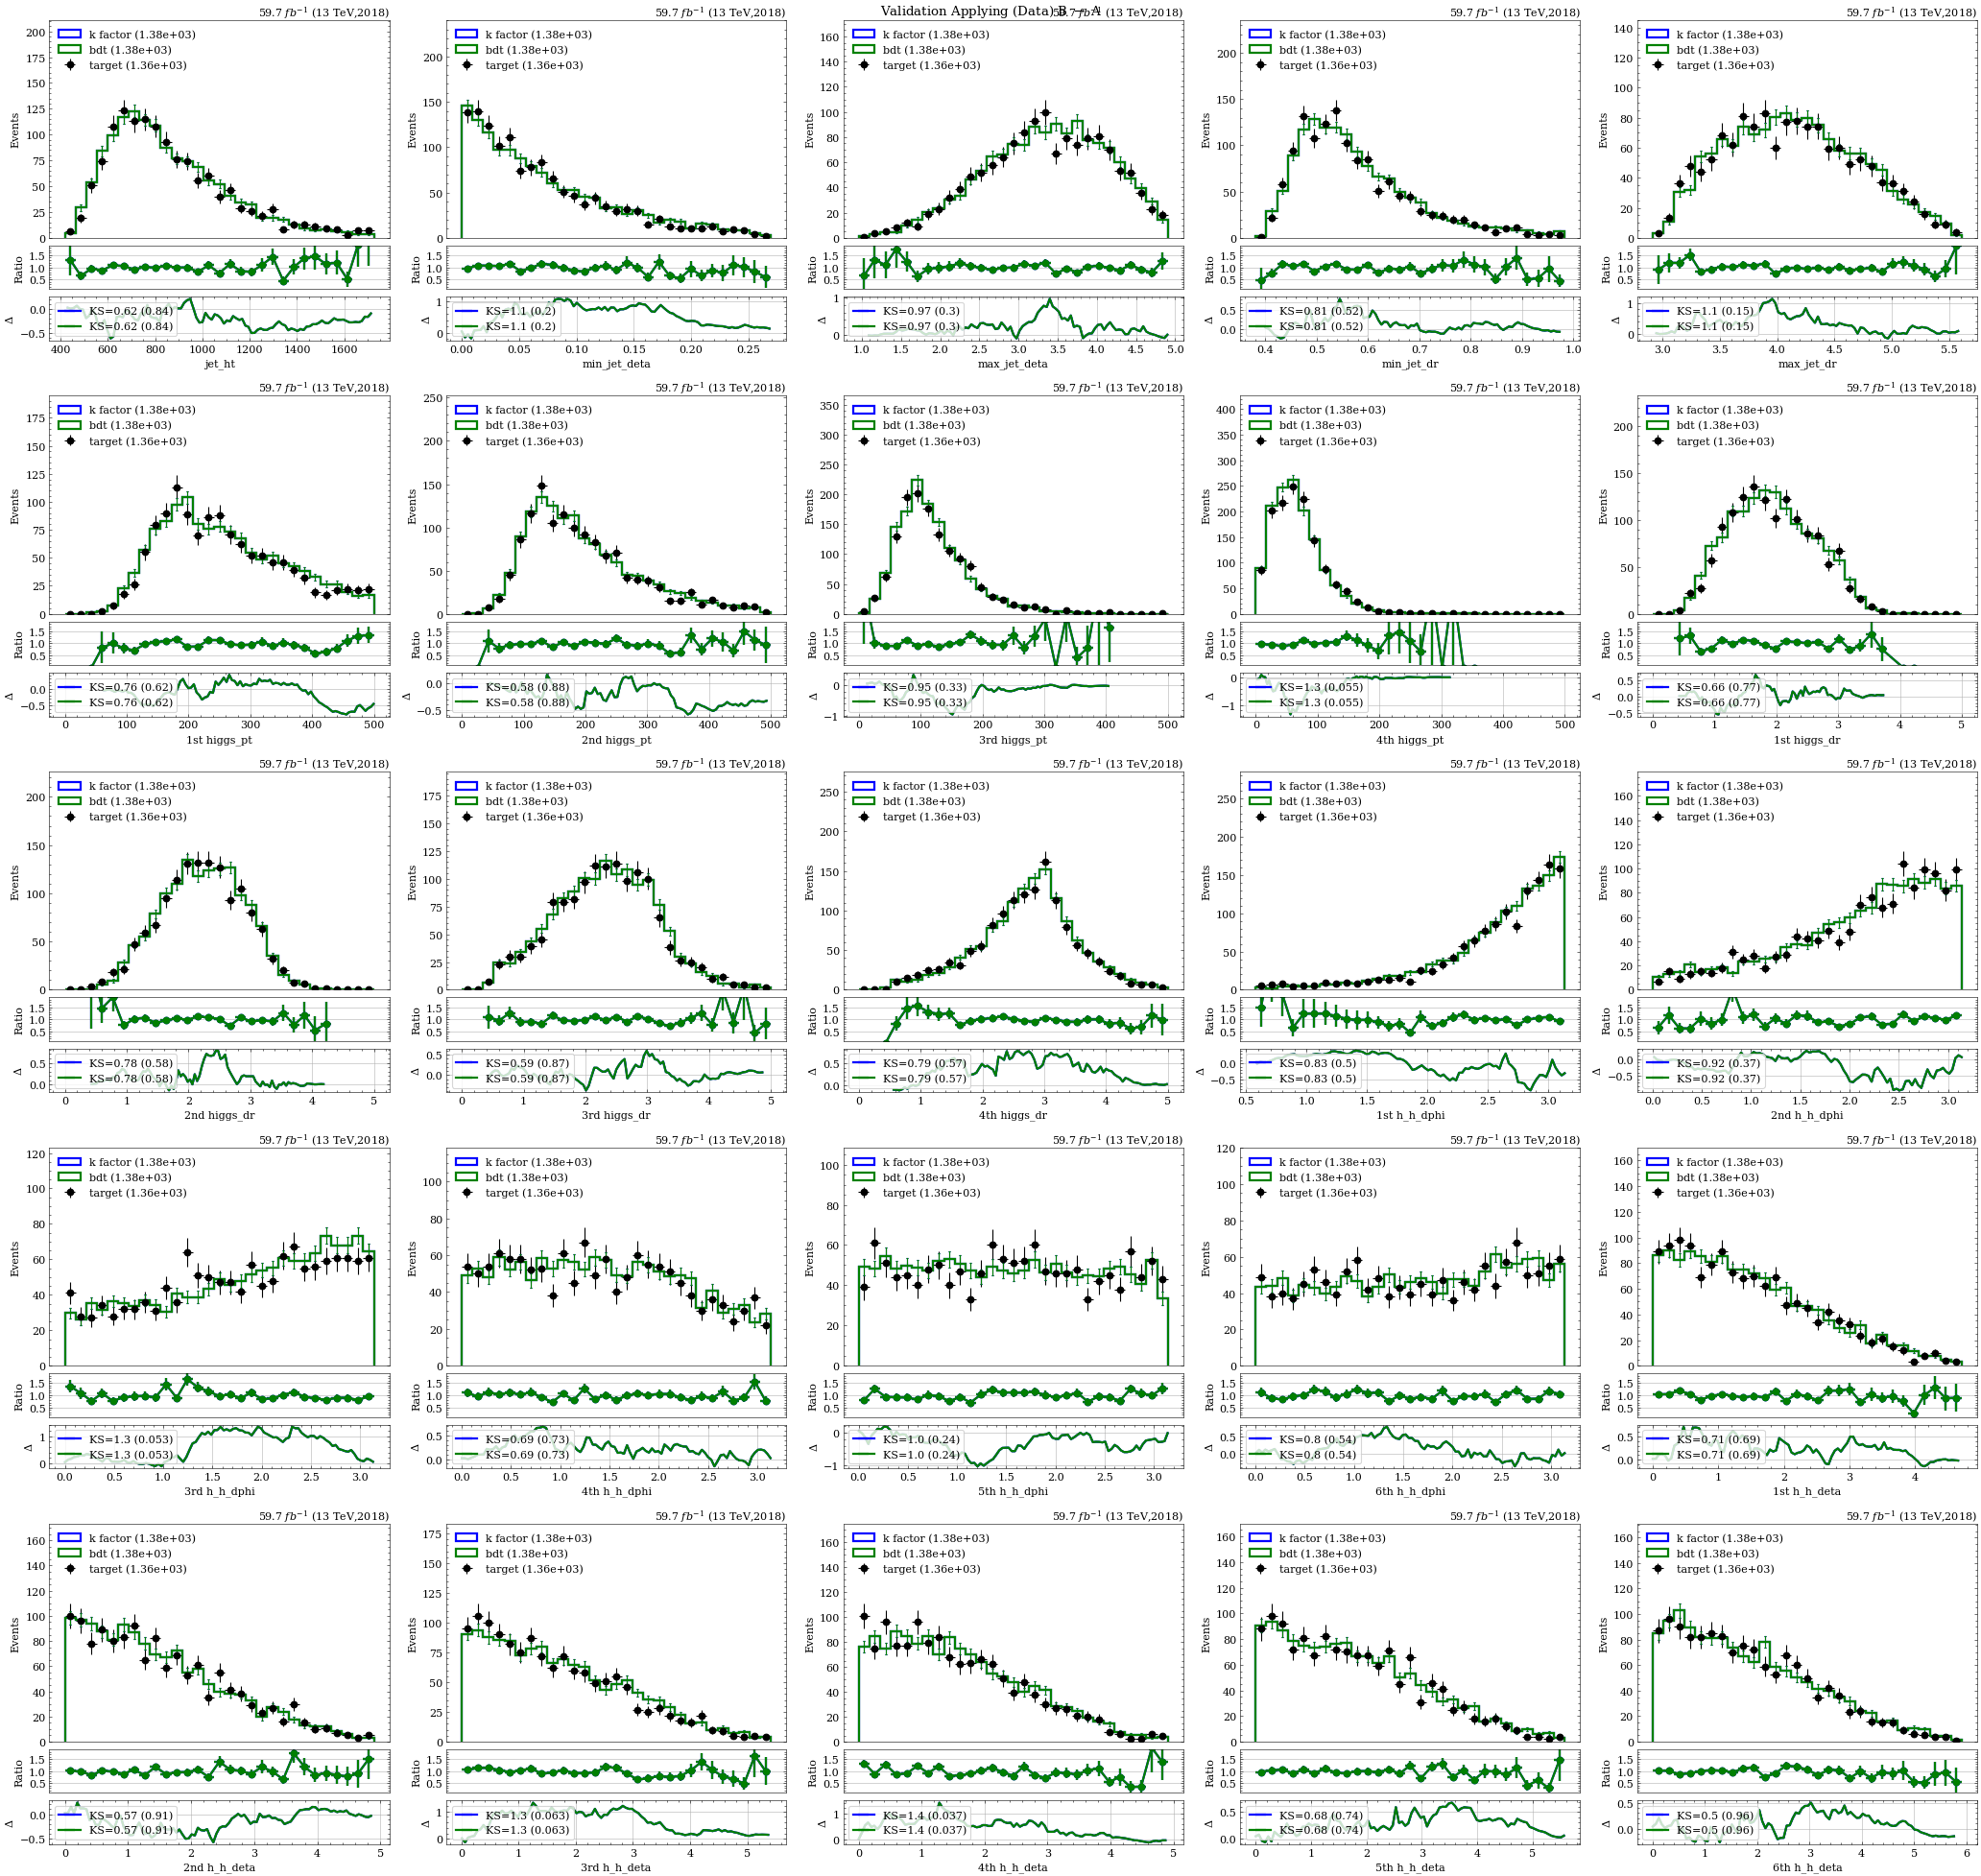

In [81]:
study.quick_region(
    blinded_data , bkg_model, bkg_model, label=['target','k factor','bdt'],
    h_color=['black','blue','green'], legend=True,
    masks=[vr_bdt.a]*len(data)+[vr_bdt.b]*(len(bkg_model)*2),
    scale=[1]*len(data)+[vr_bdt.scale_tree]*len(bkg_model)+[vr_bdt.reweight_tree]*len(bkg_model),
    varlist=vr_bdt.feature_names,
    suptitle='Validation Applying (Data) B $\\rightarrow$ A',
    ratio=True,
    **study.kstest,
    saveas=f'{dout}/vr_bdt/applying',
)

In [82]:
ar_bdt.train(bkg_model)
ar_bdt.print_results(bkg_model)

--- ABCD Results ---
k = 3.094e-01
k*(b/a)-1  = inf%
BDT(b)/a-1 = inf%



100%|██████████| 1/1 [00:20<00:00, 20.92s/it]


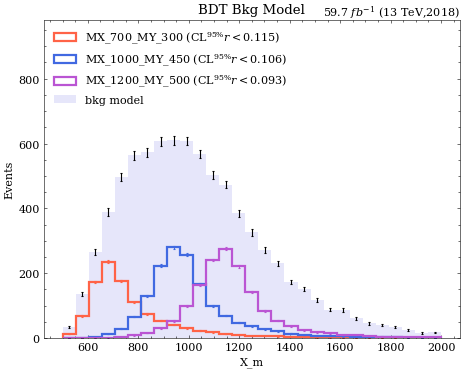

In [83]:
study.quick(
    signal + bkg_model, 
    legend=True,
    masks=[ar_bdt.a]*len(signal)+[ar_bdt.b]*len(bkg_model),
    scale=[1]*len(signal)+[ar_bdt.reweight_tree]*len(bkg_model),
    varlist=['X_m'],
    binlist=[(500,2000,30)],
    title='BDT Bkg Model',
    limits=True,
    saveas=f'{dout}/limits/bdt_bkg_model'
)